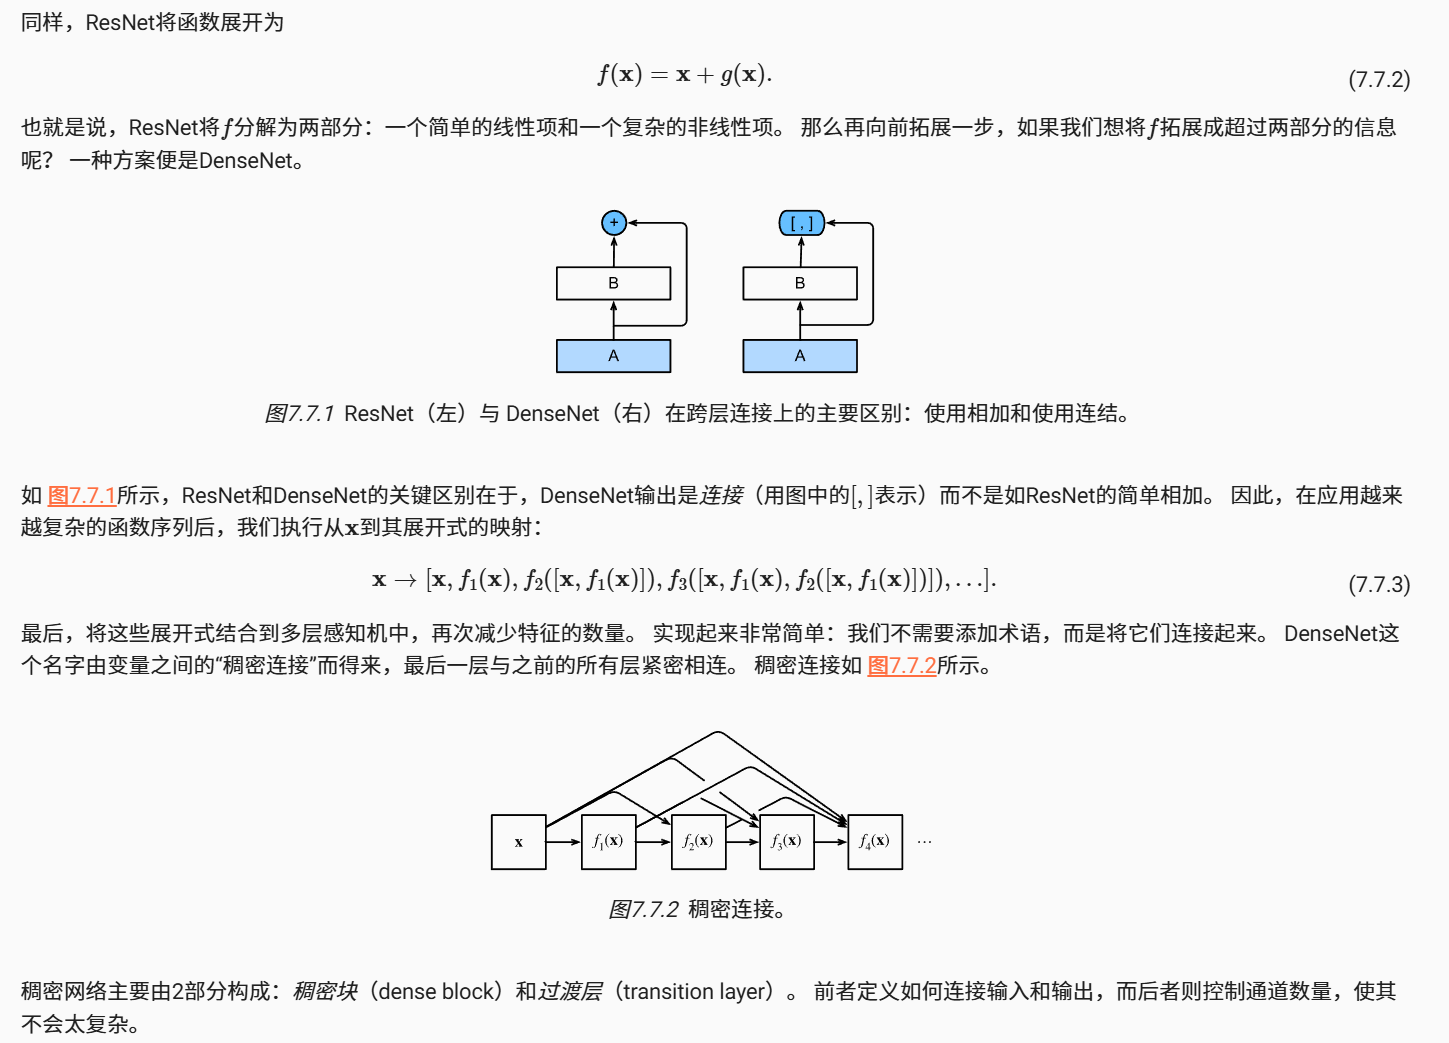

In [1]:
# 稠密块体
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 参考ResNet的改良版：将卷积层、BN层、激活层改为BN层、激活层、卷积层
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

In [3]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels
            ))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上的每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X


In [4]:
# 例子；定义一个有2个输出通道数为10的DenseBlock
# 使用通道数为3的输入时，我们会得到3 + 2 * 10 = 23 的输出
# 卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [5]:
# 过渡层
# 由于每个稠密块都会带来通道数的增加，使用过多会过于复杂化模型
# 过渡层通过1*1的卷积层来减小通道数，并使用步幅为2的avgpooling层减半高和宽，从而降低模型复杂度
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

In [6]:
# 对上一个例子中稠密块的输出使用通道数为10的过渡层
# 此时输出的通道数减为10，高和宽均减半
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [7]:
# DenseNet模型
# 首先使用同ResNet一样的单卷积层和max pooling
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),  # 宽高减半
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)  # 宽高减半
)

In [8]:
# 类似于ResNet的4个残差块，DenseNet使用4个稠密块
# 可以设置每个稠密块使用多少个卷积层，这里我们设置成4（和ResNet-18保持一致）
# 稠密块里的卷积层通道数（即增长率）设置为32，所以每个稠密块将增加128个通道
# 每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。

# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_conv_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i , num_convs in enumerate(num_conv_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    num_channels += num_convs * growth_rate  # 上一个稠密块的输出通道
    if i != len(num_conv_in_dense_blocks):
        # 在稠密块之间添加一个转换层，是通道数量减半
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [9]:
# 与ResNet类似，最后接上全局汇聚层和全连接层来输出结果
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

loss 0.148, train acc 0.946, test acc 0.783
98.6 examples/sec on cuda:0


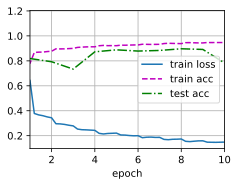

In [10]:
# 训练模型
# 由于这里使用了比较深的网络，我们将输入高和宽从224降到96来简化计算
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.144, train acc 0.949, test acc 0.857
202.3 examples/sec on cuda:0


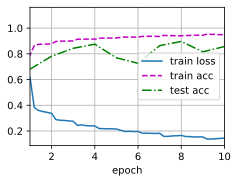

In [10]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())